In [1]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
import torchvision
import torch.nn.functional as F
from torch import optim
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

**# Dataset Processing**

In [2]:
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=224, width=224),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=224, width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

data_path = '/content/drive/MyDrive/AI/Datasets/D0' 

image_paths = [] 
classes = [] 

for data_path in glob.glob(data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    image_paths.append(glob.glob(data_path + '/*'))
    
image_paths = list(flatten(image_paths))
random.shuffle(image_paths)

train_image_paths, valid_test_image_paths = image_paths[:int(0.7*len(image_paths))], image_paths[int(0.7*len(image_paths)):]
valid_image_paths, test_image_paths = valid_test_image_paths[:int(0.7*len(valid_test_image_paths))], valid_test_image_paths[int(0.7*len(valid_test_image_paths)):]

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

class D0Dataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label
    
train_dataset = D0Dataset(train_image_paths,train_transforms)
valid_dataset = D0Dataset(valid_image_paths,test_transforms)
test_dataset = D0Dataset(test_image_paths,test_transforms)


train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

Train size: 3155
Valid size: 947
Test size: 406


# Visualize datasets

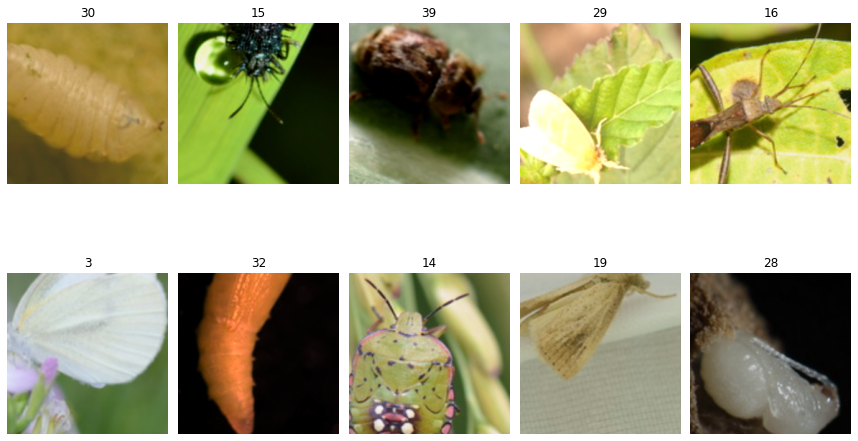

In [ ]:
%matplotlib inline

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

# **Define Model, Loss Function, Optimizer**

**DenseNet121 + D0 - Done**

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(1024, 40)
)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# **Training and save Model**

In [ ]:
# Training Function 
train_model_training_loss_ls = []
train_model_training_accuracy_ls = []
validation_model_training_loss_ls = []
validation_model_training_accuracy_ls = [] 
best_accuracy = 0.0 

print("Begin training...") 
for epoch in range(1, 31): 
    running_train_loss = 0.0 
    running_accuracy = 0.0
    running_train_accuracy = 0.0  
    running_vall_loss = 0.0 
    val_total = 0
    train_total = 0 

    # Training Loop 
    for i, data in enumerate(train_loader, 0):
        inputs, outputs = data
        inputs, outputs = inputs.to(device), outputs.to(device)
        optimizer.zero_grad()          
        predicted_outputs = model(inputs)
        train_loss = loss_func(predicted_outputs, outputs)
        train_loss.backward()
        optimizer.step()
        running_train_loss +=train_loss.item()
        train_total += outputs.size(0)
        _, predicted = torch.max(predicted_outputs, 1) 
        running_train_accuracy += (predicted == outputs).sum().item()

              
    train_loss_value = running_train_loss/len(train_loader)
    train_accuracy = (running_train_accuracy / train_total)
    train_model_training_loss_ls.append(train_loss_value)
    train_model_training_accuracy_ls.append(train_accuracy)     
    with torch.no_grad(): 
        model.eval() 
        for data in valid_loader: 
            inputs, outputs = data 
            inputs, outputs = inputs.to(device), outputs.to(device)
            predicted_outputs = model(inputs) 
            val_loss = loss_func(predicted_outputs, outputs) 
          
            _, predicted = torch.max(predicted_outputs, 1) 
            running_vall_loss += val_loss.item()  
            val_total += outputs.size(0) 
            running_accuracy += (predicted == outputs).sum().item() 


    val_loss_value = running_vall_loss/len(valid_loader) 
    val_accuracy = (running_accuracy / val_total)     
    validation_model_training_loss_ls.append(val_loss_value)        
    validation_model_training_accuracy_ls.append(val_accuracy)
    if val_accuracy > best_accuracy: 
        PATH = '/content/drive/MyDrive/AI/V2_DenseNet121_D0'
        torch.save(model.state_dict(), PATH) 
        best_accuracy = val_accuracy 
      
    print('Epoch', epoch, 'Training Loss: %.4f;' %train_loss_value, 'Validation Loss: %.4f;' %val_loss_value, 'Training Acccuracy: %.4f;' %train_accuracy, 'Validation Acccuracy: %.4f;' %val_accuracy)

Begin training...
Epoch 1 Training Loss: 5.3324; Validation Loss: 1.7299; Training Acccuracy: 0.2165; Validation Acccuracy: 0.6315;
Epoch 2 Training Loss: 2.4194; Validation Loss: 1.2976; Training Acccuracy: 0.4054; Validation Acccuracy: 0.6779;
Epoch 3 Training Loss: 1.4024; Validation Loss: 0.6204; Training Acccuracy: 0.6231; Validation Acccuracy: 0.8237;
Epoch 4 Training Loss: 0.9375; Validation Loss: 0.3649; Training Acccuracy: 0.7334; Validation Acccuracy: 0.8965;
Epoch 5 Training Loss: 0.7947; Validation Loss: 0.3014; Training Acccuracy: 0.7823; Validation Acccuracy: 0.9071;
Epoch 6 Training Loss: 0.6586; Validation Loss: 0.3459; Training Acccuracy: 0.8155; Validation Acccuracy: 0.9102;
Epoch 7 Training Loss: 0.5437; Validation Loss: 0.1713; Training Acccuracy: 0.8485; Validation Acccuracy: 0.9599;
Epoch 8 Training Loss: 0.4815; Validation Loss: 0.1603; Training Acccuracy: 0.8624; Validation Acccuracy: 0.9641;
Epoch 9 Training Loss: 0.4786; Validation Loss: 0.2702; Training Acccu

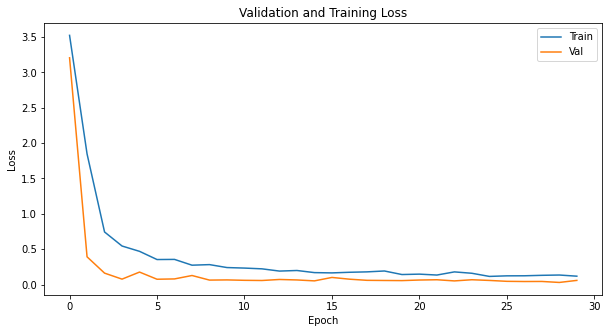

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation and Training Loss")
plt.plot(train_model_training_loss_ls,label="Train")
plt.plot(validation_model_training_loss_ls,label="Val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


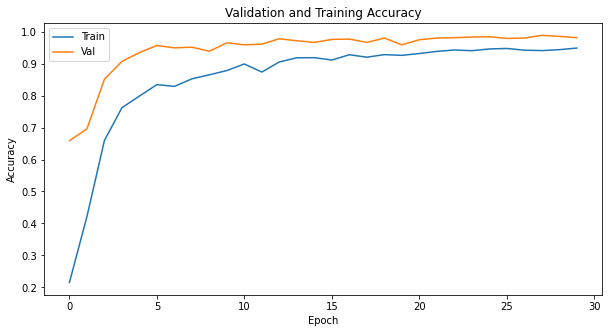

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation and Training Accuracy")
plt.plot(train_model_training_accuracy_ls,label="Train")
plt.plot(validation_model_training_accuracy_ls,label="Val")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(2048, 40)
)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [ ]:
# Training Function 
train_model_training_loss_ls = []
train_model_training_accuracy_ls = []
validation_model_training_loss_ls = []
validation_model_training_accuracy_ls = [] 
best_accuracy = 0.0 

print("Begin training...") 
for epoch in range(1, 31): 
    running_train_loss = 0.0 
    running_accuracy = 0.0
    running_train_accuracy = 0.0  
    running_vall_loss = 0.0 
    val_total = 0
    train_total = 0 

    # Training Loop 
    for i, data in enumerate(train_loader, 0):
        inputs, outputs = data
        inputs, outputs = inputs.to(device), outputs.to(device)
        optimizer.zero_grad()          
        predicted_outputs = model(inputs)
        train_loss = loss_func(predicted_outputs, outputs)
        train_loss.backward()
        optimizer.step()
        running_train_loss +=train_loss.item()
        train_total += outputs.size(0)
        _, predicted = torch.max(predicted_outputs, 1) 
        running_train_accuracy += (predicted == outputs).sum().item()

              
    train_loss_value = running_train_loss/len(train_loader)
    train_accuracy = (running_train_accuracy / train_total)
    train_model_training_loss_ls.append(train_loss_value)
    train_model_training_accuracy_ls.append(train_accuracy)     
    with torch.no_grad(): 
        model.eval() 
        for data in valid_loader: 
            inputs, outputs = data 
            inputs, outputs = inputs.to(device), outputs.to(device)
            predicted_outputs = model(inputs) 
            val_loss = loss_func(predicted_outputs, outputs) 
          
            _, predicted = torch.max(predicted_outputs, 1) 
            running_vall_loss += val_loss.item()  
            val_total += outputs.size(0) 
            running_accuracy += (predicted == outputs).sum().item() 


    val_loss_value = running_vall_loss/len(valid_loader) 
    val_accuracy = (running_accuracy / val_total)     
    validation_model_training_loss_ls.append(val_loss_value)        
    validation_model_training_accuracy_ls.append(val_accuracy)
    if val_accuracy > best_accuracy: 
        PATH = '/content/drive/MyDrive/AI/V2_WideResNet502_D0'
        torch.save(model.state_dict(), PATH) 
        best_accuracy = val_accuracy 
      
    print('Epoch', epoch, 'Training Loss: %.4f;' %train_loss_value, 'Validation Loss: %.4f;' %val_loss_value, 'Training Acccuracy: %.4f;' %train_accuracy, 'Validation Acccuracy: %.4f;' %val_accuracy)

Begin training...
Epoch 1 Training Loss: 3.5222; Validation Loss: 3.2052; Training Acccuracy: 0.0872; Validation Acccuracy: 0.2503;
Epoch 2 Training Loss: 1.8474; Validation Loss: 0.3930; Training Acccuracy: 0.5176; Validation Acccuracy: 0.8838;
Epoch 3 Training Loss: 0.7442; Validation Loss: 0.1628; Training Acccuracy: 0.7838; Validation Acccuracy: 0.9535;
Epoch 4 Training Loss: 0.5457; Validation Loss: 0.0778; Training Acccuracy: 0.8409; Validation Acccuracy: 0.9820;
Epoch 5 Training Loss: 0.4705; Validation Loss: 0.1775; Training Acccuracy: 0.8609; Validation Acccuracy: 0.9535;
Epoch 6 Training Loss: 0.3546; Validation Loss: 0.0763; Training Acccuracy: 0.8951; Validation Acccuracy: 0.9789;
Epoch 7 Training Loss: 0.3566; Validation Loss: 0.0808; Training Acccuracy: 0.8941; Validation Acccuracy: 0.9789;
Epoch 8 Training Loss: 0.2748; Validation Loss: 0.1291; Training Acccuracy: 0.9192; Validation Acccuracy: 0.9683;
Epoch 9 Training Loss: 0.2829; Validation Loss: 0.0642; Training Acccu

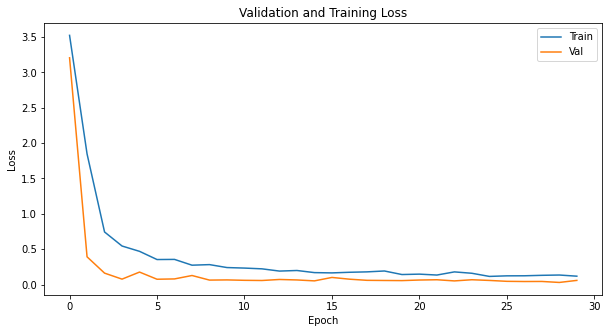

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation and Training Loss")
plt.plot(train_model_training_loss_ls,label="Train")
plt.plot(validation_model_training_loss_ls,label="Val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

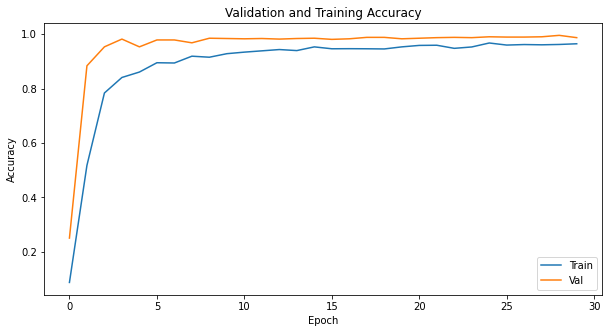

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation and Training Accuracy")
plt.plot(train_model_training_accuracy_ls,label="Train")
plt.plot(validation_model_training_accuracy_ls,label="Val")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 40)
)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Training Function 
train_model_training_loss_ls = []
train_model_training_accuracy_ls = []
validation_model_training_loss_ls = []
validation_model_training_accuracy_ls = [] 
best_accuracy = 0.0 

print("Begin training...") 
for epoch in range(1, 31): 
    running_train_loss = 0.0 
    running_accuracy = 0.0
    running_train_accuracy = 0.0  
    running_vall_loss = 0.0 
    val_total = 0
    train_total = 0 

    # Training Loop 
    for i, data in enumerate(train_loader, 0):
        inputs, outputs = data
        inputs, outputs = inputs.to(device), outputs.to(device)
        optimizer.zero_grad()          
        predicted_outputs = model(inputs)
        train_loss = loss_func(predicted_outputs, outputs)
        train_loss.backward()
        optimizer.step()
        running_train_loss +=train_loss.item()
        train_total += outputs.size(0)
        _, predicted = torch.max(predicted_outputs, 1) 
        running_train_accuracy += (predicted == outputs).sum().item()

              
    train_loss_value = running_train_loss/len(train_loader)
    train_accuracy = (running_train_accuracy / train_total)
    train_model_training_loss_ls.append(train_loss_value)
    train_model_training_accuracy_ls.append(train_accuracy)     
    with torch.no_grad(): 
        model.eval() 
        for data in valid_loader: 
            inputs, outputs = data 
            inputs, outputs = inputs.to(device), outputs.to(device)
            predicted_outputs = model(inputs) 
            val_loss = loss_func(predicted_outputs, outputs) 
          
            _, predicted = torch.max(predicted_outputs, 1) 
            running_vall_loss += val_loss.item()  
            val_total += outputs.size(0) 
            running_accuracy += (predicted == outputs).sum().item() 


    val_loss_value = running_vall_loss/len(valid_loader) 
    val_accuracy = (running_accuracy / val_total)     
    validation_model_training_loss_ls.append(val_loss_value)        
    validation_model_training_accuracy_ls.append(val_accuracy)
    if val_accuracy > best_accuracy: 
        PATH = '/content/drive/MyDrive/AI/V2_ResNet50_D0'
        torch.save(model.state_dict(), PATH) 
        best_accuracy = val_accuracy 
      
    print('Epoch', epoch, 'Training Loss: %.4f;' %train_loss_value, 'Validation Loss: %.4f;' %val_loss_value, 'Training Acccuracy: %.4f;' %train_accuracy, 'Validation Acccuracy: %.4f;' %val_accuracy)

Begin training...
Epoch 1 Training Loss: 3.4631; Validation Loss: 2.9775; Training Acccuracy: 0.1252; Validation Acccuracy: 0.2777;
Epoch 2 Training Loss: 1.7667; Validation Loss: 0.5039; Training Acccuracy: 0.5376; Validation Acccuracy: 0.8458;
Epoch 3 Training Loss: 0.8595; Validation Loss: 0.2254; Training Acccuracy: 0.7448; Validation Acccuracy: 0.9282;
Epoch 4 Training Loss: 0.6185; Validation Loss: 0.1470; Training Acccuracy: 0.8174; Validation Acccuracy: 0.9578;
Epoch 5 Training Loss: 0.4808; Validation Loss: 0.1125; Training Acccuracy: 0.8637; Validation Acccuracy: 0.9641;
Epoch 6 Training Loss: 0.5055; Validation Loss: 0.1960; Training Acccuracy: 0.8513; Validation Acccuracy: 0.9451;
Epoch 7 Training Loss: 0.4195; Validation Loss: 0.1292; Training Acccuracy: 0.8735; Validation Acccuracy: 0.9673;
Epoch 8 Training Loss: 0.3363; Validation Loss: 0.0713; Training Acccuracy: 0.8945; Validation Acccuracy: 0.9820;
Epoch 9 Training Loss: 0.3439; Validation Loss: 0.0642; Training Acccu

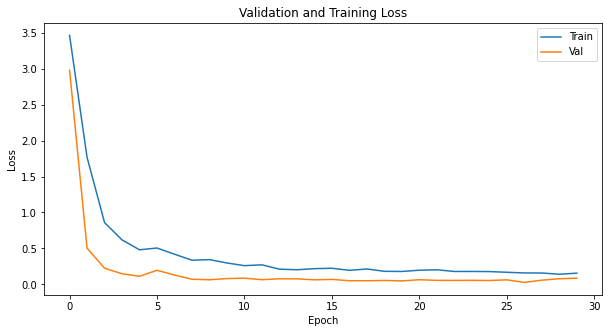

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation and Training Loss")
plt.plot(train_model_training_loss_ls,label="Train")
plt.plot(validation_model_training_loss_ls,label="Val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

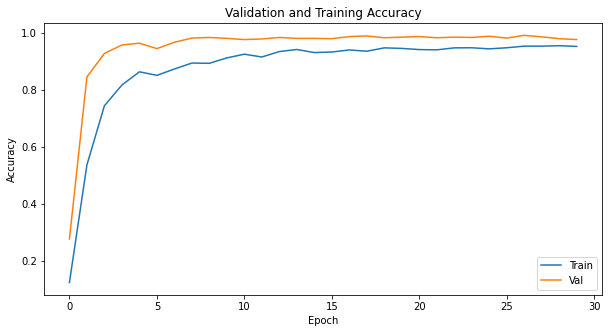

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation and Training Accuracy")
plt.plot(train_model_training_accuracy_ls,label="Train")
plt.plot(validation_model_training_accuracy_ls,label="Val")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# **ResNet50 From Zero**

In [3]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)
def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)

model = ResNet50(3, 40)
model.eval()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [ ]:
# Training Function 
train_model_training_loss_ls = []
train_model_training_accuracy_ls = []
validation_model_training_loss_ls = []
validation_model_training_accuracy_ls = [] 
best_accuracy = 0.0 

print("Begin training...") 
for epoch in range(1, 201): 
    running_train_loss = 0.0 
    running_accuracy = 0.0
    running_train_accuracy = 0.0  
    running_vall_loss = 0.0 
    val_total = 0
    train_total = 0 

    # Training Loop 
    for i, data in enumerate(train_loader, 0):
        inputs, outputs = data
        inputs, outputs = inputs.to(device), outputs.to(device)
        optimizer.zero_grad()          
        predicted_outputs = model(inputs)
        train_loss = loss_func(predicted_outputs, outputs)
        train_loss.backward()
        optimizer.step()
        running_train_loss +=train_loss.item()
        train_total += outputs.size(0)
        _, predicted = torch.max(predicted_outputs, 1) 
        running_train_accuracy += (predicted == outputs).sum().item()

              
    train_loss_value = running_train_loss/len(train_loader)
    train_accuracy = (running_train_accuracy / train_total)
    train_model_training_loss_ls.append(train_loss_value)
    train_model_training_accuracy_ls.append(train_accuracy)     
    with torch.no_grad(): 
        model.eval() 
        for data in valid_loader: 
            inputs, outputs = data 
            inputs, outputs = inputs.to(device), outputs.to(device)
            predicted_outputs = model(inputs) 
            val_loss = loss_func(predicted_outputs, outputs) 
          
            _, predicted = torch.max(predicted_outputs, 1) 
            running_vall_loss += val_loss.item()  
            val_total += outputs.size(0) 
            running_accuracy += (predicted == outputs).sum().item() 


    val_loss_value = running_vall_loss/len(valid_loader) 
    val_accuracy = (running_accuracy / val_total)     
    validation_model_training_loss_ls.append(val_loss_value)        
    validation_model_training_accuracy_ls.append(val_accuracy)
    if val_accuracy > best_accuracy: 
        PATH = '/content/drive/MyDrive/AI/V2_ResNet50_From_Zero_D0'
        torch.save(model.state_dict(), PATH) 
        best_accuracy = val_accuracy 
      
    print('Epoch', epoch, 'Training Loss: %.4f;' %train_loss_value, 'Validation Loss: %.4f;' %val_loss_value, 'Training Acccuracy: %.4f;' %train_accuracy, 'Validation Acccuracy: %.4f;' %val_accuracy)

Begin training...
Epoch 1 Training Loss: 3.6887; Validation Loss: 3.6864; Training Acccuracy: 0.0250; Validation Acccuracy: 0.0201;
Epoch 2 Training Loss: 3.6852; Validation Loss: 3.6829; Training Acccuracy: 0.0323; Validation Acccuracy: 0.0380;
Epoch 3 Training Loss: 3.6820; Validation Loss: 3.6797; Training Acccuracy: 0.0361; Validation Acccuracy: 0.0718;
Epoch 4 Training Loss: 3.6789; Validation Loss: 3.6762; Training Acccuracy: 0.0580; Validation Acccuracy: 0.0623;
Epoch 5 Training Loss: 3.6760; Validation Loss: 3.6731; Training Acccuracy: 0.0523; Validation Acccuracy: 0.0581;
Epoch 6 Training Loss: 3.6724; Validation Loss: 3.6700; Training Acccuracy: 0.0510; Validation Acccuracy: 0.0581;
Epoch 7 Training Loss: 3.6692; Validation Loss: 3.6668; Training Acccuracy: 0.0510; Validation Acccuracy: 0.0581;
Epoch 8 Training Loss: 3.6664; Validation Loss: 3.6636; Training Acccuracy: 0.0510; Validation Acccuracy: 0.0581;
Epoch 9 Training Loss: 3.6631; Validation Loss: 3.6599; Training Acccu

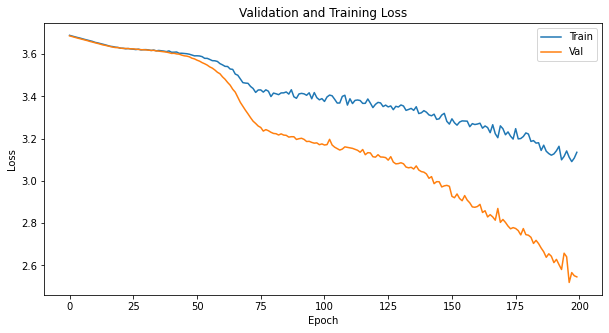

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation and Training Loss")
plt.plot(train_model_training_loss_ls,label="Train")
plt.plot(validation_model_training_loss_ls,label="Val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

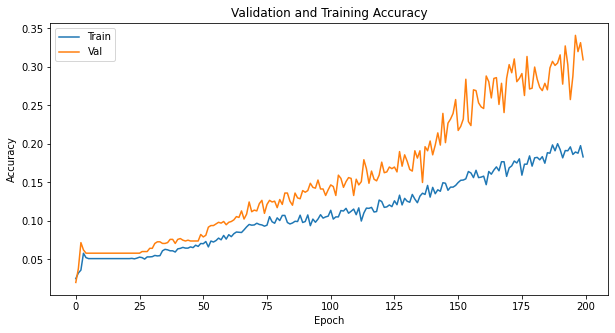

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation and Training Accuracy")
plt.plot(train_model_training_accuracy_ls,label="Train")
plt.plot(validation_model_training_accuracy_ls,label="Val")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, inf, outf, stride, drop):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(inf)
        self.conv1 = nn.Conv2d(inf, outf, kernel_size=3, padding=1,
                               stride=stride, bias=False)
        self.drop = nn.Dropout(drop, inplace=True)
        self.bn2 = nn.BatchNorm2d(outf)
        self.conv2 = nn.Conv2d(outf, outf, kernel_size=3, padding=1,
                               stride=1, bias=False)
        if inf == outf:
            self.shortcut = lambda x: x
        else:
            self.shortcut = nn.Sequential(
                    nn.BatchNorm2d(inf), nn.ReLU(inplace=True),
                    nn.Conv2d(inf, outf, 3, padding=1, stride=stride, bias=False))

    def forward(self, x):
        x2 = self.conv1(F.relu(self.bn1(x)))
        x2 = self.drop(x2)
        x2 = self.conv2(F.relu(self.bn2(x2)))
        r = self.shortcut(x)
        return x2.add_(r)
class WideResNet(nn.Module):
    def __init__(self, n_grps, N, k=1, drop=0.3, first_width=16):
        super().__init__()
        layers = [nn.Conv2d(3, first_width, kernel_size=3, padding=1, bias=False)]
        # Double feature depth at each group, after the first
        widths = [first_width]
        for grp in range(n_grps):
            widths.append(first_width*(2**grp)*k)
        for grp in range(n_grps):
            layers += self._make_group(N, widths[grp], widths[grp+1],
                                       (1 if grp == 0 else 2), drop)
        layers += [nn.BatchNorm2d(widths[-1]), nn.ReLU(inplace=True),
                   nn.AdaptiveAvgPool2d(1), nn.Flatten(),
                   nn.Linear(widths[-1], 40)]
        self.features = nn.Sequential(*layers)

    def _make_group(self, N, inf, outf, stride, drop):
        group = list()
        for i in range(N):
            blk = BasicBlock(inf=(inf if i == 0 else outf), outf=outf,
                             stride=(stride if i == 0 else 1), drop=drop)
            group.append(blk)
        return group

    def forward(self, x):
        return self.features(x)
model = WideResNet(n_grps=3, N=4, k=10)
model.eval()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BasicBlock(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (drop): Dropout(p=0.3, inplace=True)
      (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (shortcut): Sequential(
        (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (2): BasicBlock(
      (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(

In [ ]:
# Training Function 
train_model_training_loss_ls = []
train_model_training_accuracy_ls = []
validation_model_training_loss_ls = []
validation_model_training_accuracy_ls = [] 
best_accuracy = 0.0 

print("Begin training...") 
for epoch in range(1, 201): 
    running_train_loss = 0.0 
    running_accuracy = 0.0
    running_train_accuracy = 0.0  
    running_vall_loss = 0.0 
    val_total = 0
    train_total = 0 

    # Training Loop 
    for i, data in enumerate(train_loader, 0):
        inputs, outputs = data
        inputs, outputs = inputs.to(device), outputs.to(device)
        optimizer.zero_grad()          
        predicted_outputs = model(inputs)
        train_loss = loss_func(predicted_outputs, outputs)
        train_loss.backward()
        optimizer.step()
        running_train_loss +=train_loss.item()
        train_total += outputs.size(0)
        _, predicted = torch.max(predicted_outputs, 1) 
        running_train_accuracy += (predicted == outputs).sum().item()

              
    train_loss_value = running_train_loss/len(train_loader)
    train_accuracy = (running_train_accuracy / train_total)
    train_model_training_loss_ls.append(train_loss_value)
    train_model_training_accuracy_ls.append(train_accuracy)     
    with torch.no_grad(): 
        model.eval() 
        for data in valid_loader: 
            inputs, outputs = data 
            inputs, outputs = inputs.to(device), outputs.to(device)
            predicted_outputs = model(inputs) 
            val_loss = loss_func(predicted_outputs, outputs) 
          
            _, predicted = torch.max(predicted_outputs, 1) 
            running_vall_loss += val_loss.item()  
            val_total += outputs.size(0) 
            running_accuracy += (predicted == outputs).sum().item() 


    val_loss_value = running_vall_loss/len(valid_loader) 
    val_accuracy = (running_accuracy / val_total)     
    validation_model_training_loss_ls.append(val_loss_value)        
    validation_model_training_accuracy_ls.append(val_accuracy)
    if val_accuracy > best_accuracy: 
        PATH = '/content/drive/MyDrive/AI/V2_WideResNet50_From_Zero_D0'
        torch.save(model.state_dict(), PATH) 
        best_accuracy = val_accuracy 
      
    print('Epoch', epoch, 'Training Loss: %.4f;' %train_loss_value, 'Validation Loss: %.4f;' %val_loss_value, 'Training Acccuracy: %.4f;' %train_accuracy, 'Validation Acccuracy: %.4f;' %val_accuracy)

Begin training...
Epoch 1 Training Loss: 3.6824; Validation Loss: 3.6636; Training Acccuracy: 0.0317; Validation Acccuracy: 0.0686;
Epoch 2 Training Loss: 3.6497; Validation Loss: 3.6284; Training Acccuracy: 0.0596; Validation Acccuracy: 0.0908;
Epoch 3 Training Loss: 3.6223; Validation Loss: 3.5610; Training Acccuracy: 0.0450; Validation Acccuracy: 0.0739;
Epoch 4 Training Loss: 3.5845; Validation Loss: 3.4595; Training Acccuracy: 0.0631; Validation Acccuracy: 0.0919;
Epoch 5 Training Loss: 3.5240; Validation Loss: 3.3377; Training Acccuracy: 0.0783; Validation Acccuracy: 0.1024;
Epoch 6 Training Loss: 3.5078; Validation Loss: 3.3297; Training Acccuracy: 0.0834; Validation Acccuracy: 0.1024;
Epoch 7 Training Loss: 3.4912; Validation Loss: 3.2864; Training Acccuracy: 0.0830; Validation Acccuracy: 0.1162;
Epoch 8 Training Loss: 3.4771; Validation Loss: 3.2939; Training Acccuracy: 0.0834; Validation Acccuracy: 0.0781;
Epoch 9 Training Loss: 3.4616; Validation Loss: 3.2216; Training Acccu

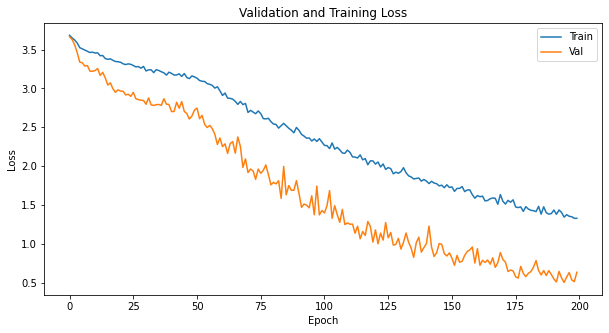

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation and Training Loss")
plt.plot(train_model_training_loss_ls,label="Train")
plt.plot(validation_model_training_loss_ls,label="Val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

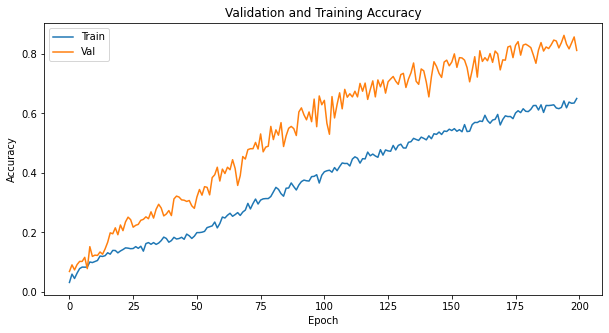

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation and Training Accuracy")
plt.plot(train_model_training_accuracy_ls,label="Train")
plt.plot(validation_model_training_accuracy_ls,label="Val")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

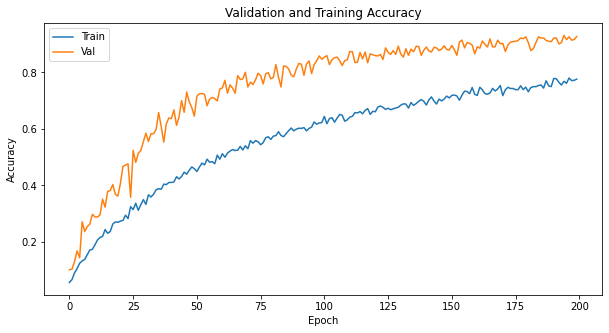

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation and Training Accuracy")
plt.plot(train_model_training_accuracy_ls,label="Train")
plt.plot(validation_model_training_accuracy_ls,label="Val")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [3]:
import collections  
class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        "Bottleneck function"
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    def forward(self, input):  # noqa: F811
        if torch.is_tensor(input):
            prev_features = [input]
        else:
            prev_features = input

        bottleneck_output = self.bn_function(prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features
class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)
class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))
        
class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=40, memory_efficient=False):

        super(DenseNet, self).__init__()

        # Convolution and pooling part from table-1
        self.features = nn.Sequential(collections.OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Add multiple denseblocks based on config 
        # for densenet-121 config: [6,12,24,16]
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                # add transition layer between denseblocks to 
                # downsample
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out
def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress,
              **kwargs):
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    return model

def densenet121(pretrained=False, progress=True, **kwargs):
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64, pretrained, progress,
                     **kwargs)
model = densenet121()
model.eval()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# Training Function 
train_model_training_loss_ls = []
train_model_training_accuracy_ls = []
validation_model_training_loss_ls = []
validation_model_training_accuracy_ls = [] 
best_accuracy = 0.0 

print("Begin training...") 
for epoch in range(1, 201): 
    running_train_loss = 0.0 
    running_accuracy = 0.0
    running_train_accuracy = 0.0  
    running_vall_loss = 0.0 
    val_total = 0
    train_total = 0 

    # Training Loop 
    for i, data in enumerate(train_loader, 0):
        inputs, outputs = data
        inputs, outputs = inputs.to(device), outputs.to(device)
        optimizer.zero_grad()          
        predicted_outputs = model(inputs)
        train_loss = loss_func(predicted_outputs, outputs)
        train_loss.backward()
        optimizer.step()
        running_train_loss +=train_loss.item()
        train_total += outputs.size(0)
        _, predicted = torch.max(predicted_outputs, 1) 
        running_train_accuracy += (predicted == outputs).sum().item()

              
    train_loss_value = running_train_loss/len(train_loader)
    train_accuracy = (running_train_accuracy / train_total)
    train_model_training_loss_ls.append(train_loss_value)
    train_model_training_accuracy_ls.append(train_accuracy)     
    with torch.no_grad(): 
        model.eval() 
        for data in valid_loader: 
            inputs, outputs = data 
            inputs, outputs = inputs.to(device), outputs.to(device)
            predicted_outputs = model(inputs) 
            val_loss = loss_func(predicted_outputs, outputs) 
          
            _, predicted = torch.max(predicted_outputs, 1) 
            running_vall_loss += val_loss.item()  
            val_total += outputs.size(0) 
            running_accuracy += (predicted == outputs).sum().item() 


    val_loss_value = running_vall_loss/len(valid_loader) 
    val_accuracy = (running_accuracy / val_total)     
    validation_model_training_loss_ls.append(val_loss_value)        
    validation_model_training_accuracy_ls.append(val_accuracy)
    if val_accuracy > best_accuracy: 
        PATH = '/content/drive/MyDrive/AI/V2_DenseNet121_From_Zero_D0'
        torch.save(model.state_dict(), PATH) 
        best_accuracy = val_accuracy 
      
    print('Epoch', epoch, 'Training Loss: %.4f;' %train_loss_value, 'Validation Loss: %.4f;' %val_loss_value, 'Training Acccuracy: %.4f;' %train_accuracy, 'Validation Acccuracy: %.4f;' %val_accuracy)

Begin training...
Epoch 1 Training Loss: 3.6492; Validation Loss: 3.5121; Training Acccuracy: 0.0564; Validation Acccuracy: 0.1014;
Epoch 2 Training Loss: 3.5780; Validation Loss: 3.3680; Training Acccuracy: 0.0666; Validation Acccuracy: 0.1035;
Epoch 3 Training Loss: 3.5069; Validation Loss: 3.2439; Training Acccuracy: 0.0903; Validation Acccuracy: 0.1309;
Epoch 4 Training Loss: 3.4630; Validation Loss: 3.1442; Training Acccuracy: 0.1052; Validation Acccuracy: 0.1679;
Epoch 5 Training Loss: 3.3884; Validation Loss: 3.1066; Training Acccuracy: 0.1242; Validation Acccuracy: 0.1436;
Epoch 6 Training Loss: 3.3493; Validation Loss: 2.9246; Training Acccuracy: 0.1328; Validation Acccuracy: 0.2714;
Epoch 7 Training Loss: 3.2772; Validation Loss: 2.8032; Training Acccuracy: 0.1379; Validation Acccuracy: 0.2365;
Epoch 8 Training Loss: 3.2026; Validation Loss: 2.7309; Training Acccuracy: 0.1550; Validation Acccuracy: 0.2545;
Epoch 9 Training Loss: 3.1895; Validation Loss: 2.6793; Training Acccu

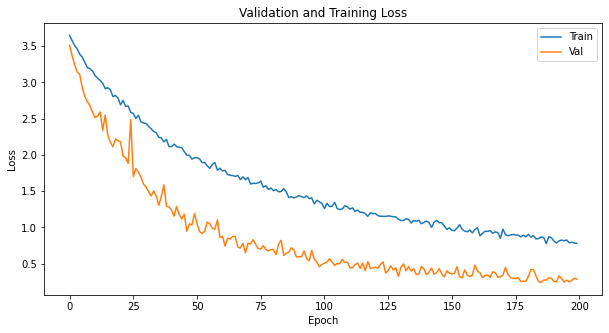

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation and Training Loss")
plt.plot(train_model_training_loss_ls,label="Train")
plt.plot(validation_model_training_loss_ls,label="Val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# **Load Model and Testing**

In [10]:
PATH = '/content/drive/MyDrive/AI/V2_DenseNet121_From_Zero_D0'
model = densenet121()

model.load_state_dict(torch.load(PATH))
model = model.to(device)
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the total test images: {100 * correct // total} %')


Accuracy of the network on the total test images: 96 %


In [4]:
PATH = '/content/drive/MyDrive/AI/V2_ResNet50_From_Zero_D0'
model = ResNet50(3, 40)

model.load_state_dict(torch.load(PATH))
model = model.to(device)
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the total test images: {100 * correct // total} %')


Accuracy of the network on the total test images: 32 %


In [8]:
PATH = '/content/drive/MyDrive/AI/V2_WideResNet50_From_Zero_D0'
model = WideResNet(n_grps=3, N=4, k=10)

model.load_state_dict(torch.load(PATH))
model = model.to(device)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the total test images: {100 * correct // total} %')


Accuracy of the network on the total test images: 89 %


In [5]:
PATH = '/content/drive/MyDrive/AI/V2_WideResNet_50_2_D0'
model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(2048, 40)
)
model.load_state_dict(torch.load(PATH))
model = model.to(device)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the total test images: {100 * correct // total} %')


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

Accuracy of the network on the total test images: 99 %


In [12]:
PATH = '/content/drive/MyDrive/AI/V2_WideResNet_D0_Sparse_Learning'
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 40),nn.LogSoftmax(dim=1)
)
model.load_state_dict(torch.load(PATH))
model = model.to(device)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the total test images: {100 * correct // total} %')


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Accuracy of the network on the total test images: 72 %


In [6]:
PATH = '/content/drive/MyDrive/AI/V2_DenseNet121_D0'
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(1024, 40)
)
model.load_state_dict(torch.load(PATH))
model = model.to(device)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the total test images: {100 * correct // total} %')


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Accuracy of the network on the total test images: 99 %


In [8]:
PATH = '/content/drive/MyDrive/AI/V2_ResNet50_D0'
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 40)
)
model.load_state_dict(torch.load(PATH))
model = model.to(device)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the total test images: {100 * correct // total} %')


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Accuracy of the network on the total test images: 99 %
